# Bias in AI Estimate $\theta$

Reads from F1-hybrids were aligned to updated parental genomes and compared using `sam_compare.py`. A read can align equally to both references, or better to one reference. These ASE read counts were then used to estimate allelic imbalance (AI) using a Poisson Gamma (PG) Bayesian model. The PG model estimates AI ($\theta$) after accounting for bias in the form of the parameter `q`. Here four distinct `q`'s were used to estimate AI. First, 3 empirical values of `q` (0.4, 0.5, 0.6). These 3 `q`'s were treated as fixed in the PG model, and were selected because previous AI studies with parental DNA, found that bias typically fell into this range. Mapping bias was also estimated using a simulation study (qsim). For the majority of exonic regions, the bias parameter `qsim` was 0.5, however for some exonic regions `qsim` deviates from 0.5 indicating that there is genome ambiguity in these regions.

While the PG model tries to account for bias, the distribution of $\theta$ still shows some bias in the form of distinct shoulders or skewed distributions of $\theta$.

In [1]:
# Set-up default environment
%run '../ipython_startup.py'

Importing commonly used libraries: os, sys, numpy as np, scipy as sp, pandas as pd, matplotlib as mp, matplotlib.pyplot as plt, datetime as dt, mclib_Python/flagging as fg
Creating project level variables: MCLAB = /home/jfear/mclab, PROJ = /home/jfear/mclab/cegs_ase_paper, TODAY = 20150813
Adding ['scripts/mclib_Python', 'scripts/ase_Python'] to PYTHONPATH


In [2]:
# Import additional libraries
import panel_plot as pplt

In [3]:
# Import Bayesian results
dat = pd.read_csv(os.path.join(PROJ, 'pipeline_output/ase_bayesian_qsim_emp_theta_w_flag.csv'))

In [4]:
# Plot r101 to show bias
grp = dat[dat['line'] == 'r101'].groupby('mating_status')

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

cnt = 0
for i, val in grp:
    ax = axes[cnt]
    title = 'r101' + i
    xlabel = '  Line <----------> Tester'
    val[['q4_mean_theta', 'q5_mean_theta', 'q6_mean_theta', 'qsim_mean_theta']].plot(kind='kde', color=['b', 'r', 'g', 'k'], ax=ax)
    ax.axvline(0.5, color='k', lw=1.3)
    ax.set_xlabel(xlabel, fontsize=14, ha='center')
    ax.set_title(title, fontsize=18)
    ax.get_yaxis().set_visible(False)
    cnt += 1

**Figure 1. Distribution of $\theta$ for r101 mated (M) and virgin (V).** 

We expect that the distribution of $\theta$ should be smooth and centered at 0.5. We also expect that the empirical values (q=0.4 and q=0.6) should be shifted away from 0.5. Of concern is the 'shoulder' showing increased AI towards the LINE. These plots suggest that there are exonic regions with bias towards the LINE that were not correctly adjusted by the PG model. Different genotypes have different amounts of bias in the distribution of $\theta$.

**Figure 2. Distribution of $\theta$ for all lines.**

Similar to r101, all other genotypes show varying degrees of bias. The goal of the remainder of this document is to identify the source of bias and try to come up with a way to correct this bias so that there is not a large Type I error rate.

## Are Biased Exonic Regions Shared

Looking at the distribution of $\theta$, we were interested in seeing if the same exonic regions are biased across genotypes. This would suggest that these regions may have genome ambiguity that was not identified by qsim. To look at this I selected 3 genotypes. Two genotypes (mated r502 and r392) have extremely biased distributions while (mated r324) had small shoulders. Bland-Altman plots were used to compare these three genotypes and see if they shared biased regions.

In [5]:
# Create wide dataset with q=0.05 for r502, r392, and r324
r502 = dat[(dat['line'] == 'r502') & (dat['mating_status'] == 'M')][['fusion_id', 'q5_mean_theta']]
r392 = dat[(dat['line'] == 'r392') & (dat['mating_status'] == 'M')][['fusion_id', 'q5_mean_theta']]
r324 = dat[(dat['line'] == 'r324') & (dat['mating_status'] == 'M')][['fusion_id', 'q5_mean_theta']]

# Rename columns
r502.columns = pd.Index(['fusion_id', 'q5_r502'])
r392.columns = pd.Index(['fusion_id', 'q5_r392'])
r324.columns = pd.Index(['fusion_id', 'q5_r324'])

# merge on fusion_id.
merged = r502.merge(r392, on='fusion_id', how='outer').merge(r324, on='fusion_id', how='outer')

# Create mask for coloring exonic regions between 0.1 and 0.3
mask502 = (merged['q5_r502'] >= 0.1) & (merged['q5_r502'] <= 0.3)
mask392 = (merged['q5_r392'] >= 0.1) & (merged['q5_r392'] <= 0.3)
mask324 = (merged['q5_r324'] >= 0.1) & (merged['q5_r324'] <= 0.3)

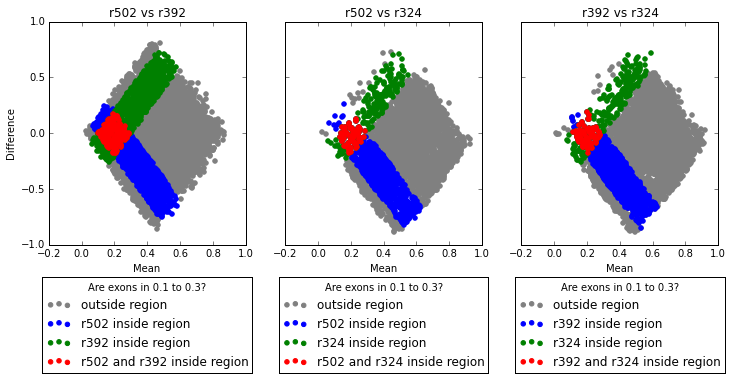

In [6]:
# BA Plots
# Calculate difference and mean
## r502 vs r392
diff12 = merged['q5_r502'] - merged['q5_r392']
mean12 = (merged['q5_r502'] + merged['q5_r392']) / 2

## r502 vs r324
diff13 = merged['q5_r502'] - merged['q5_r324']
mean13 = (merged['q5_r502'] + merged['q5_r324']) / 2

## r392 vs r324
diff23 = merged['q5_r392'] - merged['q5_r324']
mean23 = (merged['q5_r392'] + merged['q5_r324']) / 2

# BA plot with regions between 0.1 and 0.3 colored
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
## r502 vs r392
ax1.scatter(mean12[np.logical_not(mask502 | mask392)], diff12[np.logical_not(mask502 | mask392)], color='grey', label='outside region')
ax1.scatter(mean12[mask502], diff12[mask502], color='blue', label='r502 inside region')
ax1.scatter(mean12[mask392], diff12[mask392], color='green', label='r392 inside region')
ax1.scatter(mean12[mask502 & mask392], diff12[mask502 & mask392], color='red', label='r502 and r392 inside region')
ax1.set_title('r502 vs r392')
ax1.set_ylabel('Difference'); ax1.set_xlabel('Mean')
## r502 vs r324
ax2.scatter(mean13[np.logical_not(mask502 | mask324)], diff13[np.logical_not(mask502 | mask324)], color='grey', label='outside region')
ax2.scatter(mean13[mask502], diff13[mask502], color='blue', label='r502 inside region')
ax2.scatter(mean13[mask324], diff13[mask324], color='green', label='r324 inside region')
ax2.scatter(mean13[mask502 & mask324], diff13[mask502 & mask324], color='red', label='r502 and r324 inside region')
ax2.set_title('r502 vs r324')
ax2.set_xlabel('Mean')

## r392 vs r324
ax3.scatter(mean23[np.logical_not(mask502 | mask324)], diff23[np.logical_not(mask502 | mask324)], color='grey', label='outside region')
ax3.scatter(mean23[mask392], diff23[mask392], color='blue', label='r392 inside region')
ax3.scatter(mean23[mask324], diff23[mask324], color='green', label='r324 inside region')
ax3.scatter(mean23[mask392 & mask324], diff23[mask392 & mask324], color='red', label='r392 and r324 inside region')
ax3.set_title('r392 vs r324')
ax3.set_xlabel('Mean')

#plt.xlabel('Mean'); plt.ylabel('Difference'); plt.suptitle('Comparison of r502 vs r392')
ax1.legend(loc='lower center', bbox_to_anchor=(0.5, -.6), title='Are exons in 0.1 to 0.3?')
ax2.legend(loc='lower center', bbox_to_anchor=(0.5, -.6), title='Are exons in 0.1 to 0.3?')
ax3.legend(loc='lower center', bbox_to_anchor=(0.5, -.6), title='Are exons in 0.1 to 0.3?')

**Figure 3. Comparison of exonic regions with biased $\theta$.** These Bland-Altman plots show the mean $\theta$ vs the difference in $\theta$ for all exonic regions. Exonic regions that were biased towards the LINE (between 0.1-0.3) are colored.

While there are some exonic regions that overlap (red), the majority of biased exonic regions are distinct between genotypes. *However, it may be useful to remove the red exonic regions from further analysis.*

## Sources of Bias

### Number of Polymorphisms
One source of bias is the miss-calling of SNPs and INDELs. Reads are driven to align better to the LINE reference when a miss-called SNP is incorporated into the TESTER strain. This would be difficult to test without re-running the SNP filtering pipeline, which has been extensively tested and tweaked. However, we can look at the number of SNPs/INDELs and how they related to $\theta$. 

In [7]:
# Import SNP and INDEL counts
cnts = pd.read_csv(os.path.join(PROJ, 'pipeline_output/ase_summary/snp_indel_cnt_by_fusion.csv'))

# Merge Line SNP/INDEL to bias
mergedLine = pd.merge(dat[['line', 'mating_status', 'fusion_id', 'q5_mean_theta']], cnts, how='left', on=['line', 'fusion_id'])

# Merge Tester SNP/INDEL to bias
tester = dat[['line', 'mating_status', 'fusion_id', 'q5_mean_theta']].copy()
tester.loc[:, 'line'] = tester['line'].apply(lambda x: 'w1118_' + x)
mergedTester = pd.merge(tester, cnts, how='left', on=['line', 'fusion_id'])

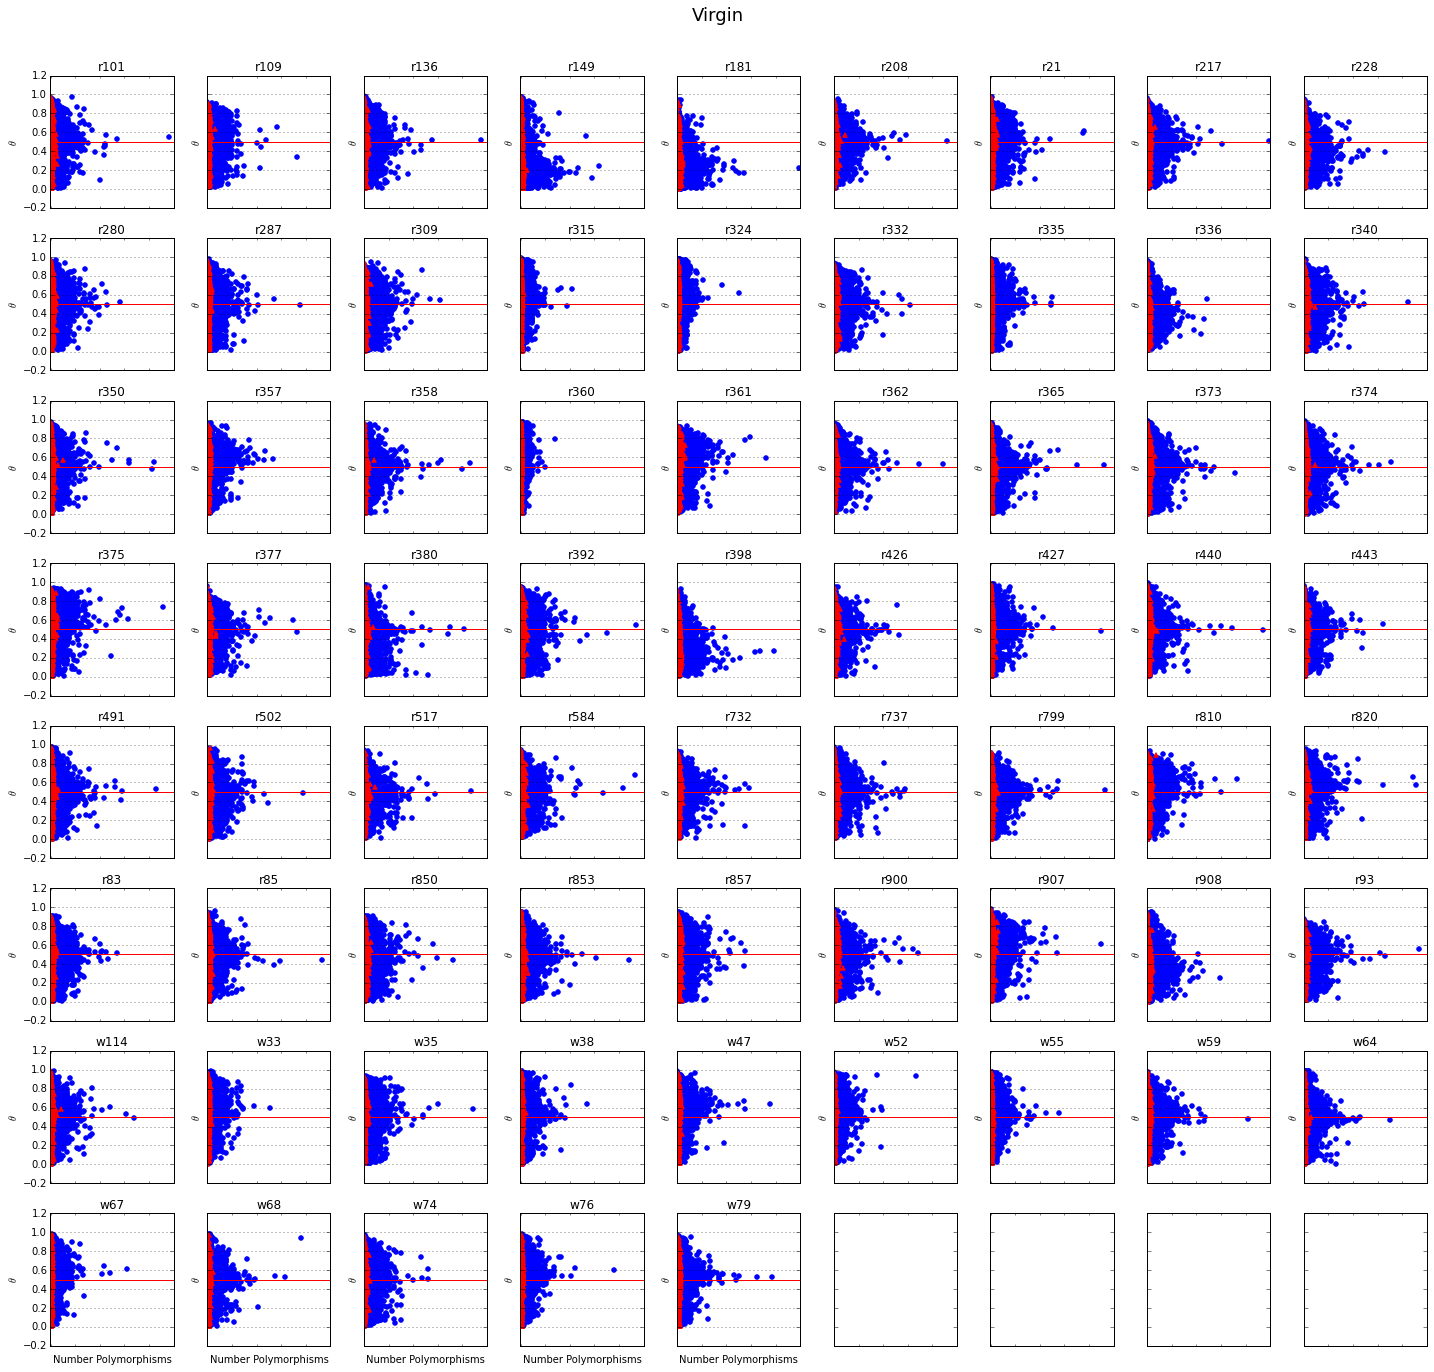

In [8]:
# Plot number of polymorphisms vs mean theta
grp = mergedLine.groupby('mating_status')

for i, val in grp:
    pplt.plotPanelSnpIndel(i, val)

**Figure 4. Relationship of number of LINE polymorphisms (x-axis) to $\theta$.** Blue circles are SNPs and red triangles are INDEls. 

When the distribution of $\theta$ deviates from 0.5 (e.g., virgin r149 and r181), there is an increase in the number of polymorphism. However, when there are shoulders in the distribution (e.g., virgin r324) there is no clear relationship with the number of polymorphisms. For many lines, exonic regions with the most polymorphisms have a $\theta$ around 0.5.

The SNP/INDEL filtering process also created a LINE specific TESTER set of SNP/INDELs. In other words, r101 had a slightly different set of w1118 SNP/INDELs than w79. The LINE specific TESTER SNP/INDELs are also plotted.

In [9]:
# Plot number of polymorphisms vs mean theta
grp = mergedTester.groupby('mating_status')

for i, val in grp:
    pplt.plotPanelSnpIndel(i, val)

**Figure 5. Relationship of number of TESTER polymorphisms (x-axis) to $\theta$.** Blue circles are SNPs and red triangles are INDELs.

Patterns are similar to LINE polymorphisms.

### Coverage

Another source of bias is the amount of coverage. When there is low coverage, there may be more exonic regions identified as having AI because of only a few reads aligning to each region. Coverage can be looked at in two ways: (1) Overall average per nucleotide coverage (APN). (2) Raw allele specific read counts.

#### Mean APN

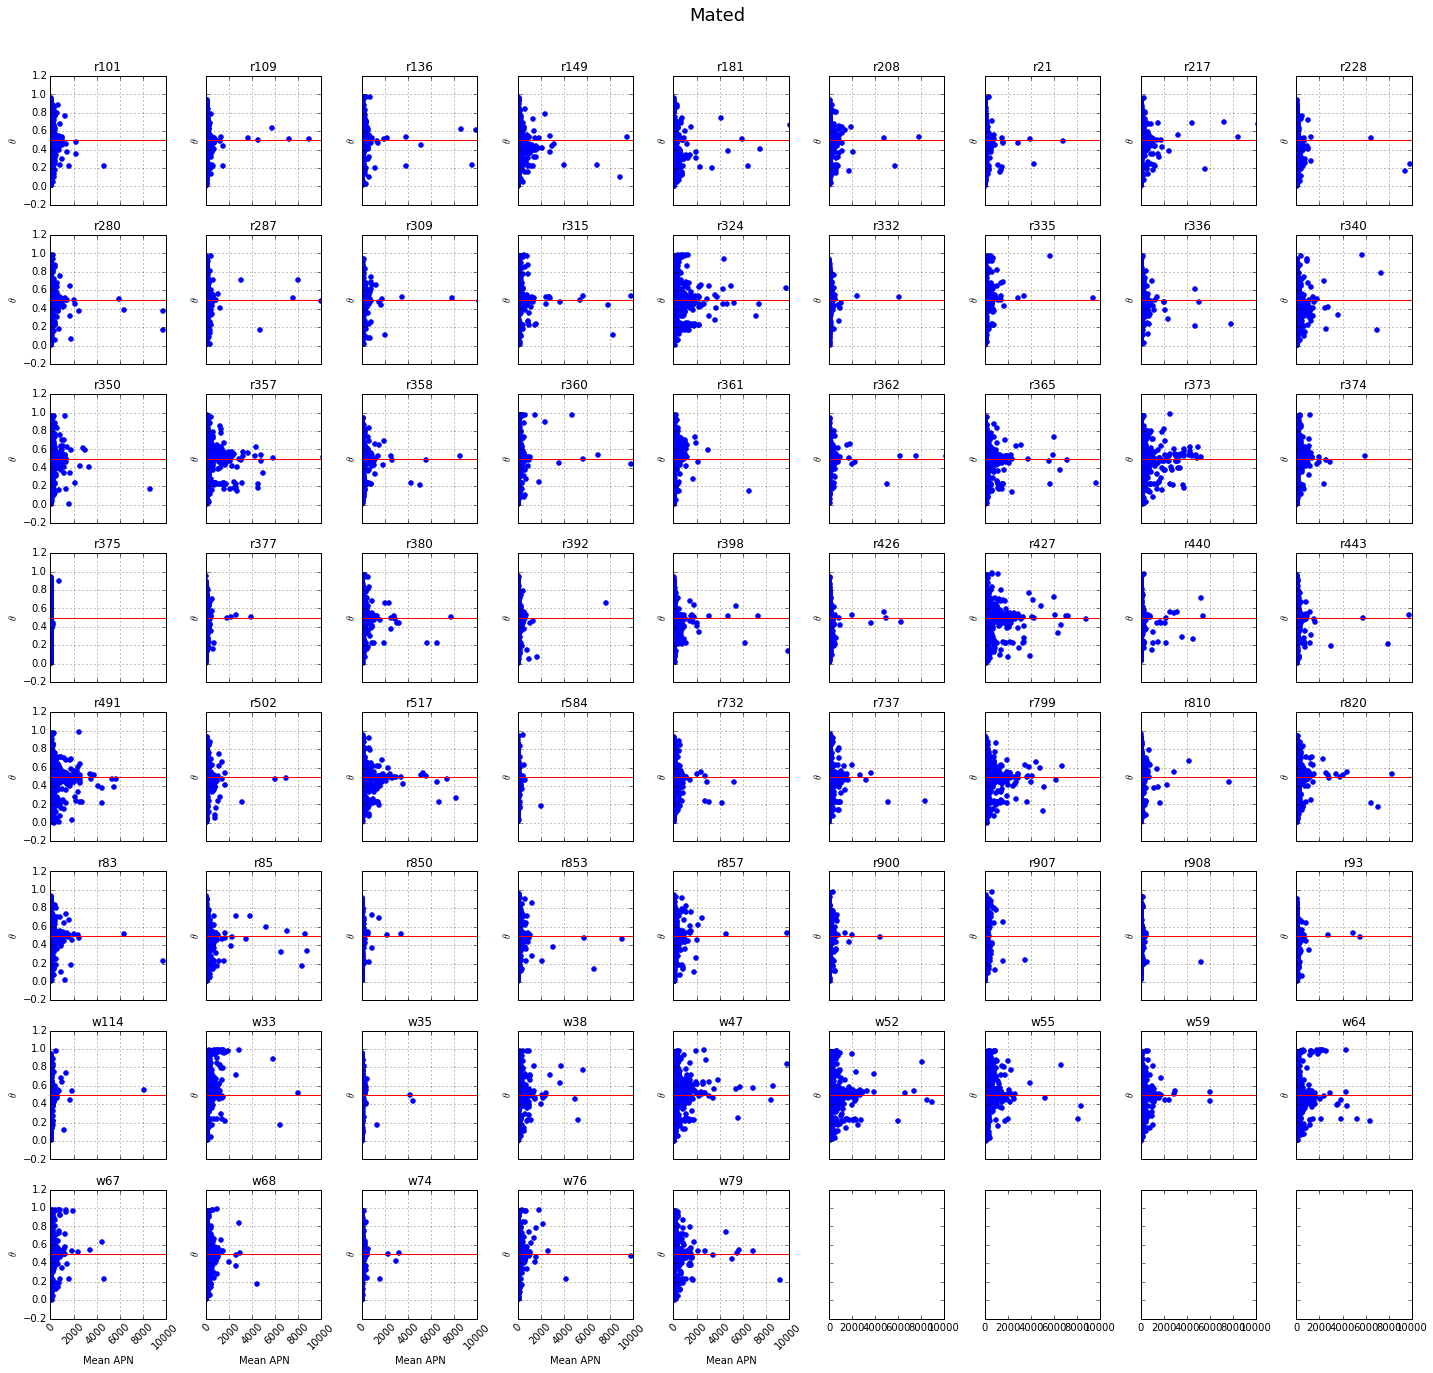

In [10]:
# Plot Mean APN vs mean theta
grp = dat.groupby('mating_status')

for i, val in grp:
    pplt.plotPanelAPN(i, val)

**Figure 6. Comparison of mean APN vs $\theta$.** 

There is a lot of variability in coverage. There are some questionable genotypes (e.g., mated r375) that appear to have overall very low coverage. Some genotypes (e.g., virgin w64) show an interesting pattern of mean APN compared to $\theta$. However, when compared to the distribution of $\theta$, w64 has small shoulders. Mean APN seems to have some relationship with bias in $\theta$, but this relationship is not very clear.

A guideline that Lauren has previously published for differential expression experiments is to remove exonic regions with an APN < 5. Here I have replotted the distribution of $\theta$ after moving low coverage exonic regions.

In [11]:
# Plot Mean APN vs mean theta for only exonic regions flagged as AI
grp = dat[dat['flag_AI_combined'] == 1].groupby('mating_status')

for i, val in grp:
    pplt.plotPanelAPN(i, val)

**Figure #. APN vs bias for exonic regions that were flagged as having AI.** I wanted to only look at exonic regions that were flagged by the PG model. Results are a little strange with some lines (i.e., r149) showing high coverage/high bias on towards the line. This matches the distribution plots.

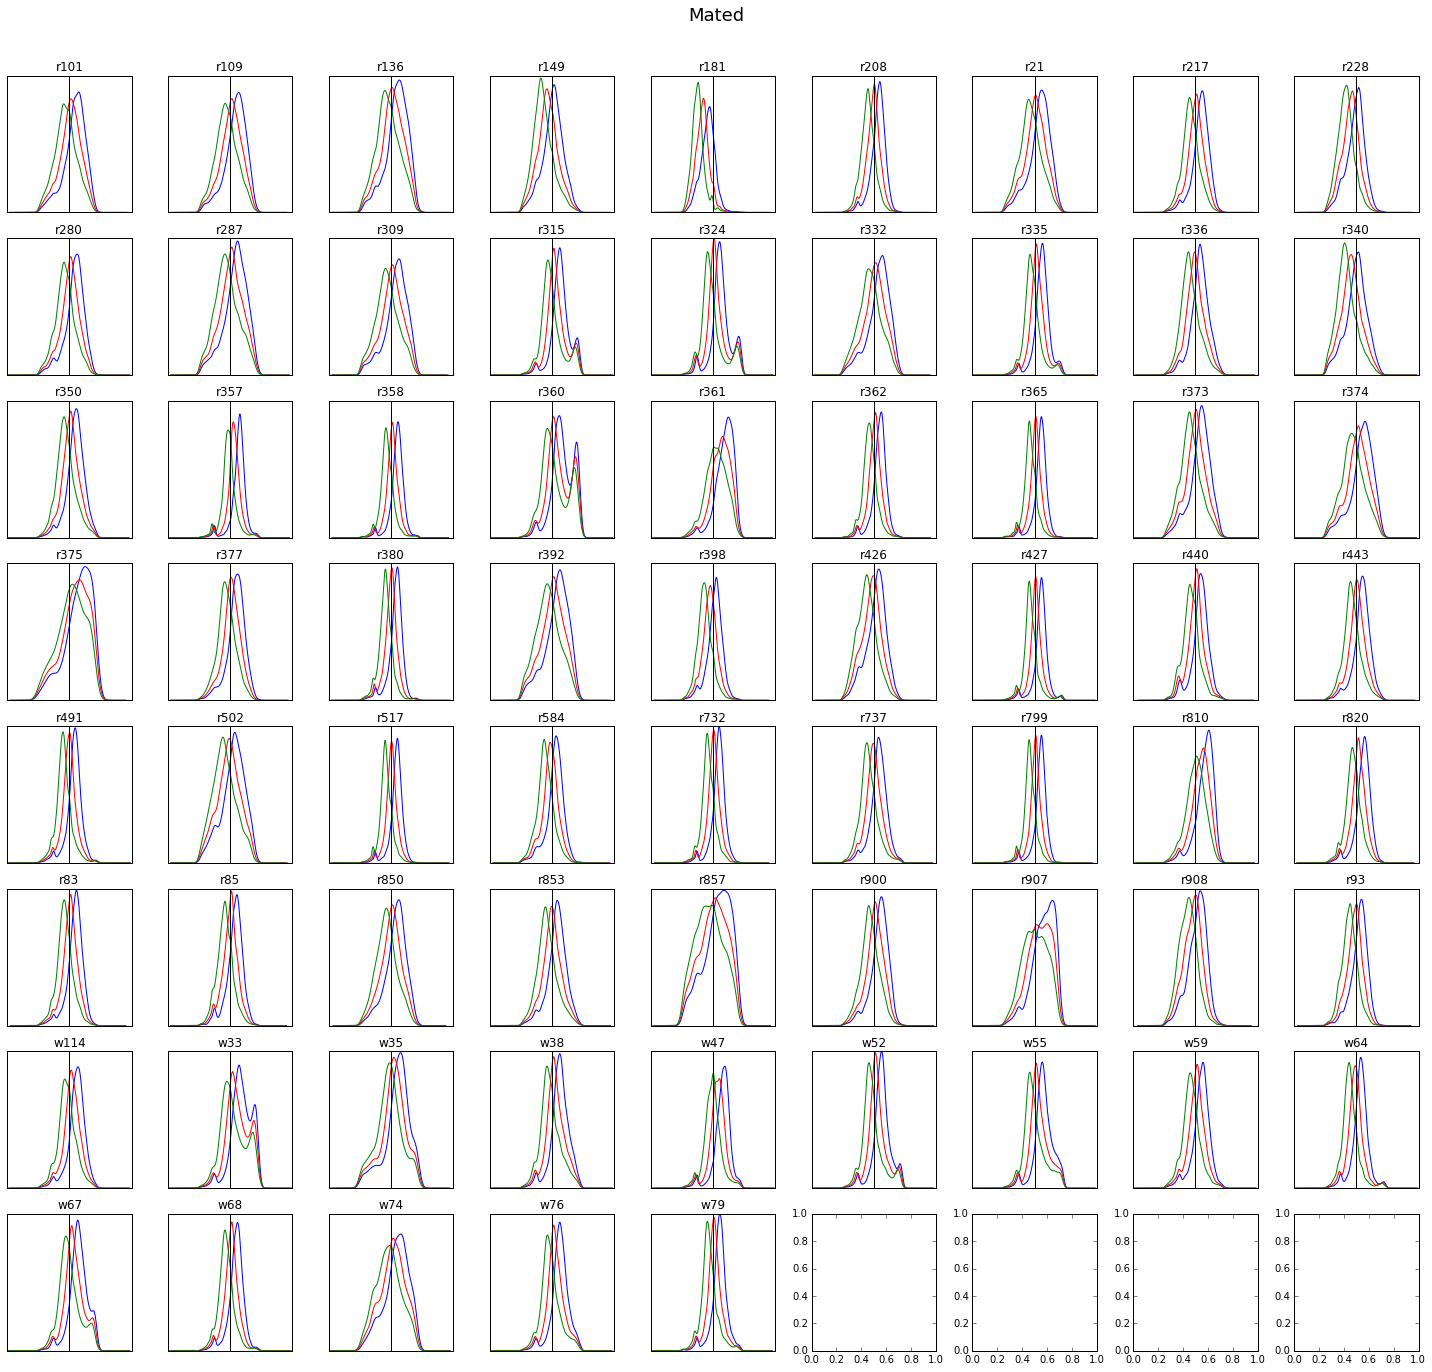

In [12]:
# Distribution of $\theta$ with APN >= 5
pplt.plotPanelKDE('M', dat[(dat['mating_status'] == 'M') & (dat['mean_apn'] >= 5)])
                   
pplt.plotPanelKDE('V', dat[(dat['mating_status'] == 'V') & (dat['mean_apn'] >= 5)])

**Figure 7. Distribution of $\theta$ for exonic regions with APN ≥ 5.** 

Removing exonic regions with an APN ≤ 5 cleaned the distribution plots for most genotypes. However, there are still some small shoulders and a few genotypes that are still skewed (e.g., virgin r398). An APN cutoff is beneficial, but is not able to fix all of the issues.

#### Raw Read Count

Instead of focusing on mean APN, I wanted to explore raw read count, so see if the number of allele specific reads could drive bias. I created some interactive graphs and played with a variety of settings (not shown here), and in general I found that requiring 5 allele specific reads from LINE and TESTER made the cleanest distribution. The issue is probably when there are only a few allele specific reads and the majority of replicates have a 0.

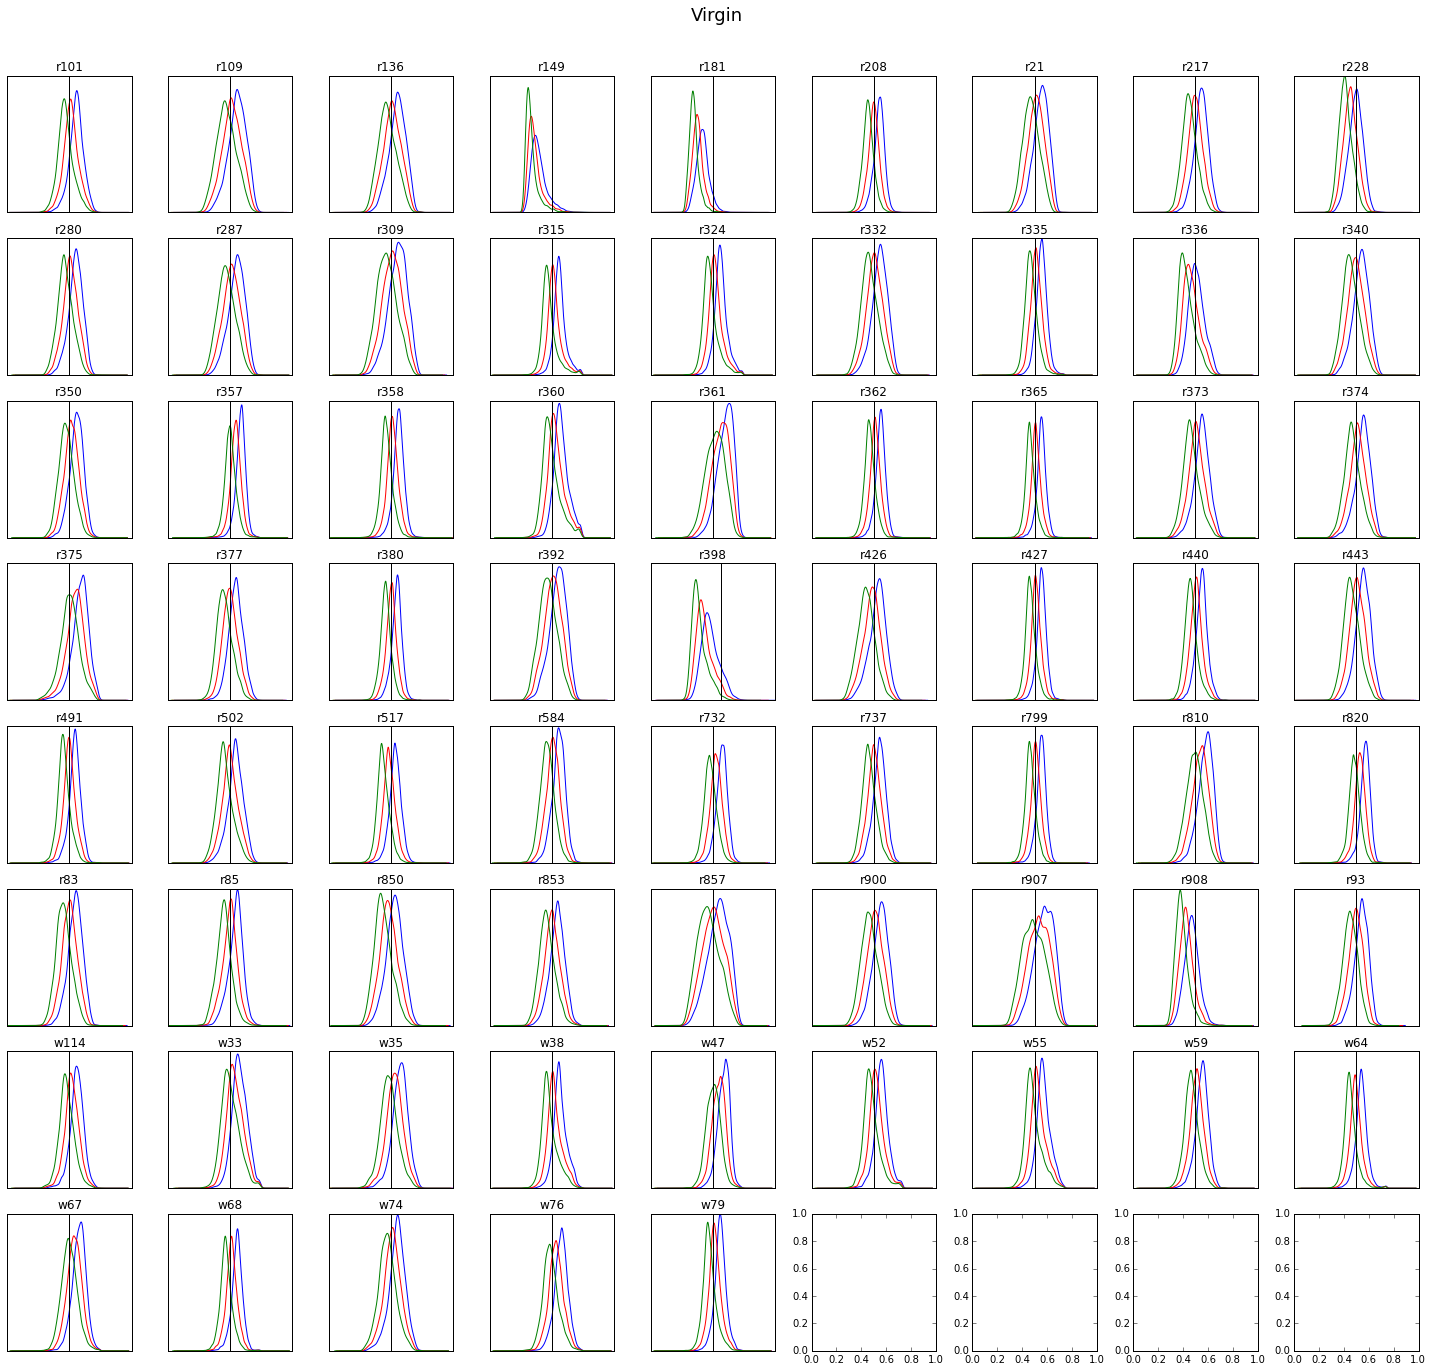

In [13]:
# Plot dist $\theta$ where a minimum of 5 allele specific reads
mask = (dat['sum_line'] >= 5) & (dat['sum_tester'] >= 5)
pplt.plotPanelKDE('M', dat[(dat['mating_status'] == 'M') & mask])
pplt.plotPanelKDE('V', dat[(dat['mating_status'] == 'V') & mask])

**Figure 8. Distribution of $\theta$ where exonic regions had at least 5 allele specific reads form LINE and TESTER.** 

These distributions look good, however the stringency of this filter may increase Type II error, because I expect there are instances of AI where all reads come from one allele. To account for this I tried a number of other filtering strategies. It looks like the best is to require at least **5 allele specific reads OR a mean APN ≥ 50**. 

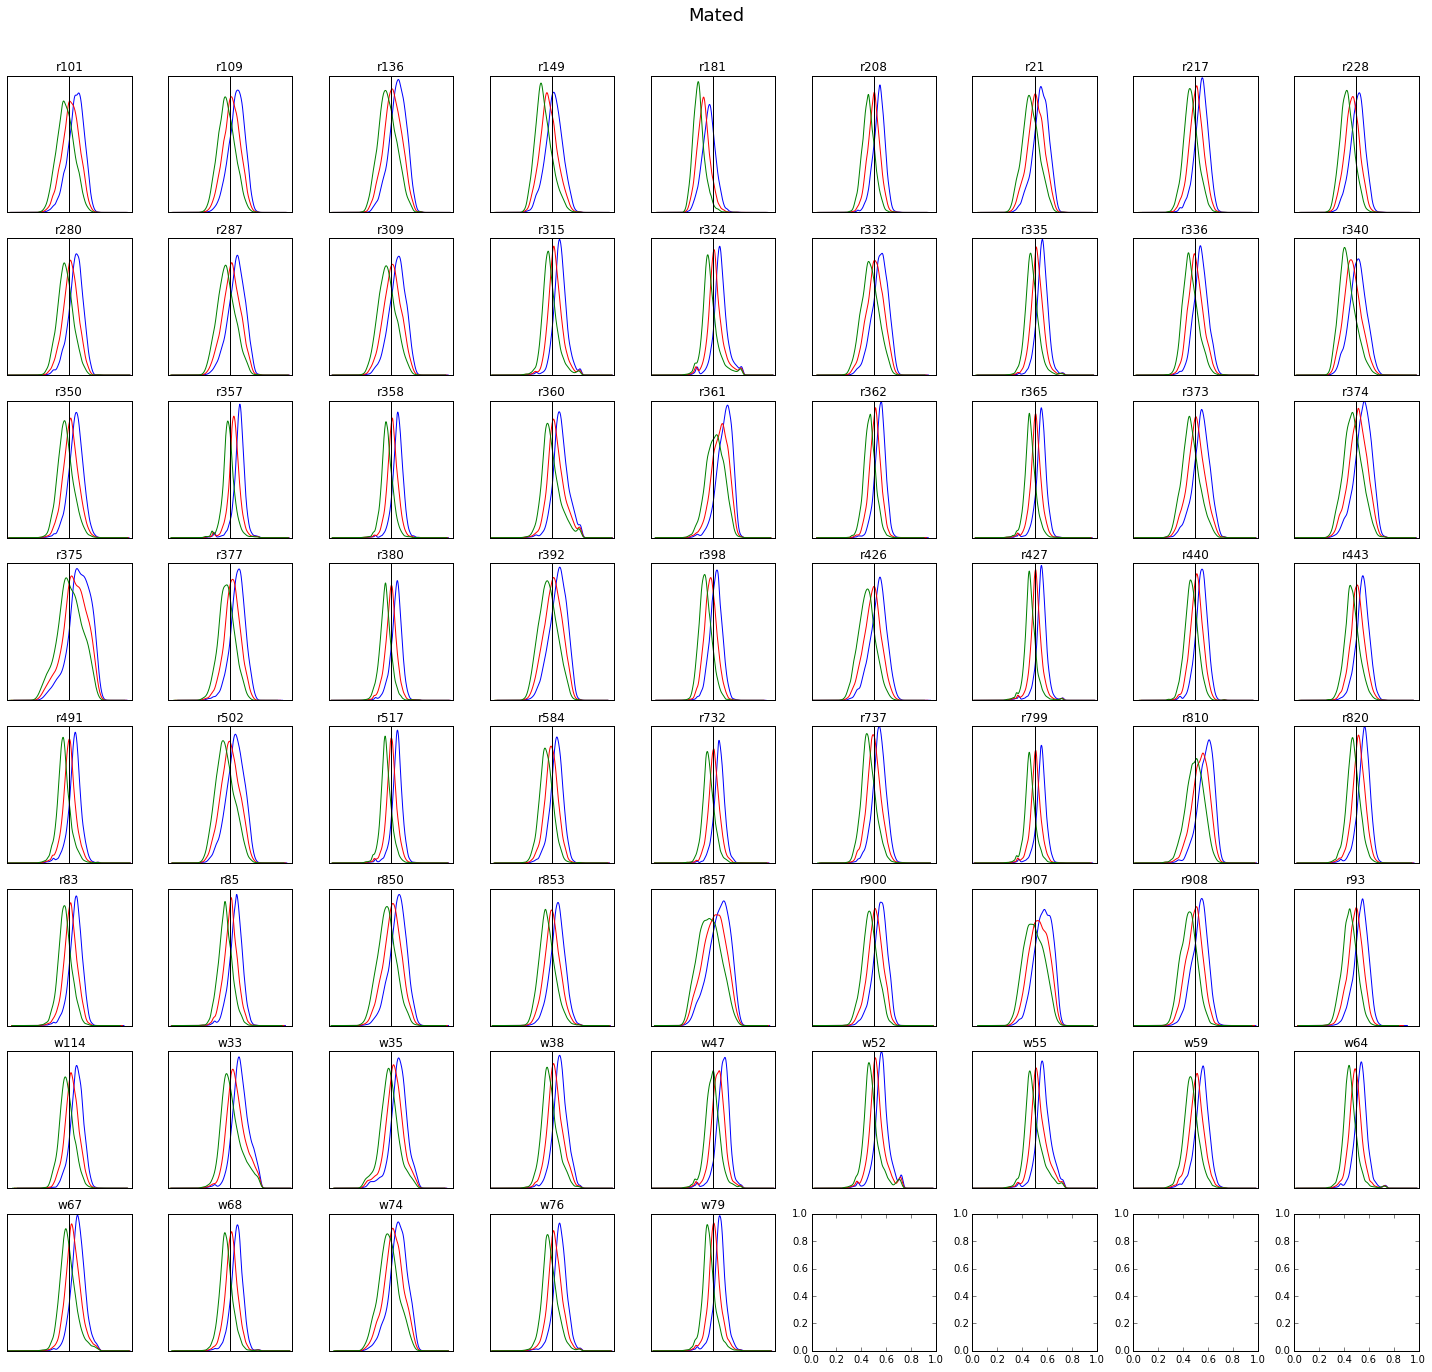

In [14]:
# Plot dist $\theta$ where a minimum of 5 allele specific reads or mean APN >= 50
mask = ((dat['sum_line'] >= 5) & (dat['sum_tester'] >= 5)) | (dat['mean_apn'] >= 50)
pplt.plotPanelKDE('M', dat[(dat['mating_status'] == 'M') & mask])
pplt.plotPanelKDE('V', dat[(dat['mating_status'] == 'V') & mask])

**Figure 9. Distribution of $\theta$ where exonic regions had at least 5 allele specific reads form LINE and TESTER or a mean APN ≥ 50.**

There are still a handful of genotypes that should be removed, but we can discuss these.

# AI Summary

Using the filter settings discussed in **Figure 9** I have done a quick summary of exonic regions showing AI. AI was called using a combination of $\theta$s from the different PG models. 

(1) If qsim is not equal to 0.5, then AI was based on the PG model where q=qsim.

(2) If qsim equals 0.5, then three empirical PG models (q = 0.4, 0.5, 0.6) had to call AI.

I realize this is very conservative, however in simulation studies this is needed to keep Type I error below 5%. 

**Table 1. AI summary after filtering.** num_exons is the number of exons remaining after filtering. num_exons_AI is the number of exons flagged as having AI using the combination method described above. pct_AI is the percent of exonic regions with AI (num_exons_AI / num_exons * 100).

In [15]:
# Make summary Table
grp = dat.groupby(['line', 'mating_status'])

# How many exonic regions are left after filtering
num_exons = pd.DataFrame(grp['fusion_id'].count())
num_exons.reset_index(inplace=True)
num_exons.columns = pd.Index(['line', 'mating_status', 'num_exons'])

# How many have AI
AI = pd.DataFrame(grp['flag_AI_combined'].value_counts())
AI.reset_index(inplace=True)
AI = AI[AI['level_2'] == 1]
AI.drop('level_2', axis=1, inplace=True)
AI.columns = pd.Index(['line', 'mating_status', 'num_exons_AI'])

# Merge and Summarize
merged = num_exons.merge(AI, how='outer', on=['line', 'mating_status'])
merged['pct_AI'] = merged['num_exons_AI'] / merged['num_exons'] * 100

# Print Summary
pd.set_option('display.max_rows', None)
merged.sort(['mating_status', 'line'])

line mating_status  num_exons  num_exons_AI     pct_AI
0    r101             M      13026          2219  17.035160
2    r109             M      12587          2042  16.223087
4    r136             M      12041          2365  19.641226
6    r149             M      14461          2820  19.500726
8    r181             M      16654          4313  25.897682
10   r208             M      15639           571   3.651129
12    r21             M      13099          2017  15.398122
14   r217             M      15846          1401   8.841348
16   r228             M      14086          1528  10.847650
18   r280             M      14118          1754  12.423856
20   r287             M      12793          2647  20.691003
22   r309             M      12515          2655  21.214543
24   r315             M      15661          2203  14.066790
26   r324             M      16243          2639  16.246999
28   r332             M      11868          1934  16.295922
30   r335             M      15508          1234   7.957183
32   r336             M      13508          1099   8.135919
34   r340             M      14649          3278  22.376954
36   r350             M      14880          1642  11.034946
38   r357             M      16871          1421   8.422737
40   r358             M      16372           619   3.780845
42   r360             M      14461          3304  22.847659
44   r361             M      14510          3968  27.346657
46   r362             M      14649           433   2.955833
48   r365             M      16542           789   4.769677
50   r373             M      14567          2760  18.946935
52   r374             M      13835          3034  21.929888
54   r375             M       7312           813  11.118709
56   r377             M       8657           430   4.967079
58   r380             M      18717          1556   8.313298
60   r392             M      12185          2671  21.920394
62   r398             M      15167           887   5.848223
64   r426             M      13364          1186   8.874588
66   r427             M      17190          1230   7.155323
68   r440             M      12464           469   3.762837
70   r443             M      11811           947   8.017949
72   r491             M      17040          1505   8.832160
74   r502             M      10577          1872  17.698780
76   r517             M      17190           692   4.025596
78   r584             M       9383           351   3.740808
80   r732             M      15037           534   3.551240
82   r737             M      14494          1309   9.031323
84   r799             M      17292           851   4.921351
86   r810             M      14114          1964  13.915261
88   r820             M      16128          1218   7.552083
90    r83             M      15421          1153   7.476817
92    r85             M      14585           804   5.512513
94   r850             M      11377          1106   9.721368
96   r853             M      13530          1741  12.867701
98   r857             M      10763          2843  26.414568
100  r900             M      13223          1171   8.855782
102  r907             M      12896          2833  21.968052
104  r908             M      12207           716   5.865487
106   r93             M      14784           659   4.457522
108  w114             M      13169          1050   7.973271
110   w33             M      14696          3842  26.143168
112   w35             M      10712          1159  10.819642
114   w38             M      14130          1942  13.743808
116   w47             M      16449          2926  17.788315
118   w52             M      14494          2182  15.054505
120   w55             M      14374          2742  19.076110
122   w59             M      15134          1501   9.918065
124   w64             M      15482          1118   7.221289
126   w67             M      13733          2211  16.099905
128   w68             M      15357           927   6.036335
130   w74             M      11253          1